In [2]:
import numpy as np
import quadpy
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tectosaur2 import gauss_rule, refine_surfaces, integrate_term, tensor_dot
from tectosaur2.laplace2d import double_layer, hypersingular
from tectosaur2.mesh import panelize_symbolic_surface
from tectosaur2.debug import plot_centers

In [3]:
n_fault=3

qx, qw = gauss_rule(7)
t = sp.var("t")

# The number of fault panels should be a multiple of 40.
# so that the kinks in the "a" parameter profile occur at panel boundaries.
edges = np.linspace(-1, 1, n_fault+1)
panel_bounds = np.stack((edges[:-1],edges[1:]), axis=1)
fault = panelize_symbolic_surface(
    t, t * 0, (t + 1) * -0.5,
    panel_bounds,
    qx, qw
)

In [4]:
from tectosaur2.mesh import build_interp_matrix, build_interpolator
Im = build_interp_matrix(build_interpolator(fault.qx), np.array([-1,1]))
Im = np.array(Im)

In [6]:
constraints.shape

(2, 21)

In [7]:
fault.n_pts

21

In [8]:
fault.pts

array([[ 0.        , -0.00848201],
       [ 0.        , -0.04307814],
       [ 0.        , -0.09902581],
       [ 0.        , -0.16666667],
       [ 0.        , -0.23430753],
       [ 0.        , -0.2902552 ],
       [ 0.        , -0.32485132],
       [ 0.        , -0.34181535],
       [ 0.        , -0.37641147],
       [ 0.        , -0.43235914],
       [ 0.        , -0.5       ],
       [ 0.        , -0.56764086],
       [ 0.        , -0.62358853],
       [ 0.        , -0.65818465],
       [ 0.        , -0.67514868],
       [ 0.        , -0.7097448 ],
       [ 0.        , -0.76569247],
       [ 0.        , -0.83333333],
       [ 0.        , -0.90097419],
       [ 0.        , -0.95692186],
       [ 0.        , -0.99151799]])

In [9]:
field = fault.pts[:,1] ** 2
field[:7] -= 1e-1
field[14:] += 1e-1
Im.dot(field[:7]), Im.dot(field[7:14]), Im.dot(field[14:])

(array([-0.1       ,  0.01111111]),
 array([0.11111111, 0.44444444]),
 array([0.54444444, 1.1       ]))

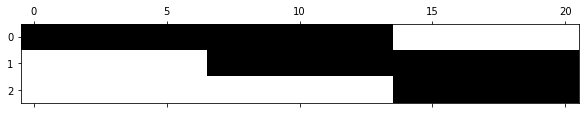

In [19]:
constraints = np.zeros((fault.n_panels, fault.n_pts))
for i in range(fault.n_panels-1):
    constraints[i,i*fault.panel_order:(i+1)*fault.panel_order] = Im[1]
    constraints[i,(i+1)*fault.panel_order:(i+2)*fault.panel_order] = -Im[0]
constraints[-1,-fault.panel_order:] = Im[1]
constraints_rhs = np.zeros(constraints.shape[0])
constraints_rhs[-1] = 1.0
plt.figure(figsize=(10,10))
plt.spy(constraints[:20,:120])
plt.show()

In [20]:
mat = np.zeros((fault.n_pts + constraints.shape[0], fault.n_pts+constraints.shape[0]))
mat[:fault.n_pts,:fault.n_pts] = np.eye(fault.n_pts)
mat[fault.n_pts:,:fault.n_pts] = constraints
mat[:fault.n_pts, fault.n_pts:] = constraints.T

In [21]:
Cfield = np.linalg.solve(mat, np.concatenate((field, constraints_rhs)))[:-3]

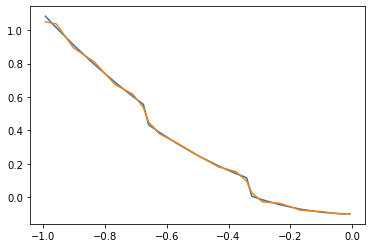

In [22]:
plt.plot(fault.pts[:,1], field)
plt.plot(fault.pts[:,1], Cfield)
plt.show()

In [27]:
# Ix + By = d
# Cx + 0y = r

# x = d - By
# C(d - By) = r
# Cd = CBy + r
# x = Fd = (I - B(CB^-1)(Cd - r))d
# x = (I - B(CB^-1)C)d - 
# F = (I - B((CB)^-1)C)d
continuity = np.eye(fault.n_pts) - constraints.T.dot(np.linalg.inv(constraints.dot(constraints.T)).dot(constraints))
y = np.linalg.inv(constraints.dot(constraints.T)).dot(constraints.dot(field) - constraints_rhs)
c = field - constraints.T.dot(np.linalg.inv(constraints.dot(constraints.T)).dot(constraints.dot(field) - constraints_rhs))
Cfield - c

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        6.93889390e-18, -3.46944695e-18,  2.42861287e-17,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        5.55111512e-17,  0.00000000e+00,  1.11022302e-16,  1.11022302e-16,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])

In [14]:
np.linalg.cond(CAiB)

NameError: name 'CAiB' is not defined